# CrossBee workflow notebook tutorial based on Python script modules for LBD

CrossBee is a system that recommends bridging terms (*b-terms*) through an ensemble-based ranking method. It aids experts in uncovering hidden connections between unrelated domains. CrossBee facilitates the ranking, exploration, and investigation of these cross-domain bridging terms. In a broader sense it implements the Swanson's `ABC` model: it looks for $b$-terms that bridge the literature on a selected $a$-term and $c$-term; $b$-terms are the candidates that can possibly explain the link.

<hr>

[1] Petrič, I., Urbančič, T., Cestnik, B., Macedoni-Lukšič, M. (2009). Literature mining method RaLoLink for uncovering relations between biomedical concepts. Journal of Biomedical Informatics, 42(2), 219–227.

[2] Juršič, M., Cestnik, B., Urbančič, T., Lavrač, N. (2012a). Cross-domain Literature Mining: Finding Bridging Concepts with CrossBee, *Proceedings of the 3rd International Conference on Computational Creativity*, 33-40.

[3] Juršič, M., Cestnik, B., Urbančič, T., Lavrač, N. (2012b). Bisociative literature mining by ensemble heuristics. In M. R. Berthold (Ed.), *Bisociative Knowledge Discovery*, 338–358. Springer.

<hr>

Note that **our motive** was to **re-implement parts** of the tools such as **CrossBee**, RaJoLink and OntoGen so that we can generally **repeat the results** with the tools from the past experiments, and not so much to optimize the written Python code. The fucus was on understanding the learning processes and visualizing the workflows in terms of repeatability of the results obtained; the efficiency and elegance of the programming can be addressed in future versions of the scripts.

Import and initialize `logging` library to track the execution of the scripts.

In [209]:
import logging

# Initialize logging with a basic configuration
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s: %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

Import LBD components from the framework notebooks. The description of the individual components from the framework notebooks can be found in the respective notebooks.

The purpose of the **import_ipynb** library is to allow the direct import of Jupyter notebooks as modules so that code, functions and classes defined in one notebook can be easily reused in other notebooks or Python scripts.
If the **import_ipynb** library is omitted (or commented out), the corresponding modules will be imported from **.py** files exported from the **.ipynb** files. Note that importing from **.py** files is usually much faster and therefore more suitable for running scripts in production.

In [210]:
# import import_ipynb
import LBD_01_data_acquisition
import LBD_02_data_preprocessing
import LBD_03_feature_extraction
import LBD_04_text_mining
import LBD_05_results_analysis
import LBD_06_visualization

Import additional Python libraries.

In [211]:
import nltk
import numpy as np
import itertools
import pandas as pd
import spacy
from sklearn.metrics.pairwise import cosine_distances
from typing import List, Dict

Define the name of the domains $C$ and $A$, then load the responding text from the input file. The expected file format is as follows:

1. The file is encoded in Ascii (if it is in UTF-8 or other encoding, it should be converted to Ascii).
2. Each line in the file represents one document. The words in each document are separated by spaces. The length of the individual documents may vary.
3. The first word in each line is the **unique id**, followed by a semicolon. Normally **pmid** (pubmed id) can be used for this purpose, alhough any unique id (e.g. **sequential count**) suffices.
4. The second word in each line can optionally stand for a predefined domain (or class) of the document. In this case, the second word is preceded by **!**. For example, if the file contains documents that originate from two domains, e.g. *migraine* and *magnesium*, the second word in each line is either **!migraine** or **!magnesium**. If the file contains documents that originate from *autism* and *calcineurin*, the second word in each line will be either **!autism** or **!calcineurin**.
5. If the second word is not preceded by **!**, it will be considered the first word of the document. In this case, the document will be given the domain **!NA** (**not applicable** or **not available**).


**A background story for this experiment**

First, we selected *autism* and *calcineurin* as our domains of interest.

*Autism*  belongs to a group of pervasive developmental disorders that are portrayed by an
early delay and abnormal development of cognitive, communication and social
interaction skills of a person. It is a very complex and not yet sufficiently understood
domain, where precise causes are still unknown; research suggests that it may be
related to genetic mutations, environmental factors, and brain structure and function. 
*Calcineurin* is a protein phosphatase with a high prevalence in the brain.

The dataset from the input file was constructed using the following PubMed query:

1. autis* [TIAB] AND 1900/01/01:2007/12/31 [PDAT]
2. calcineurin [TIAB] AND 1900/01/01:2007/12/31 [PDAT]

The input file *input/f_autism_calcineurin.txt* was prepared for the experiments described in [1]. It contains 13.623 titles and abstracts, 9.403 from *autism* and 4.220 from *calcineurin*.

In [222]:
# Set the global variable CONTEXT_SWITCH to the following values, depending on which domain pairs you would like to set as a context:
# 1 for Autism-Calcineurin
# 2 for Autism-Calcineurin on outlier documents
# 11 for Alzheimer-Macrobiota
# 12 for Alzheimer-Macrobiota on outlier documents
# 21 for Migraine-Magnesium

CONTEXT_SWITCH = 12

In [223]:
if CONTEXT_SWITCH == 1:
    domainName = 'Autism-Calcineurin'
    fileName = 'input/f_autism_calcineurin.txt'
elif CONTEXT_SWITCH == 2:
    domainName = 'Autism-Calcineurin'
    fileName = 'input/f_autism_calcineurin_outliers.txt'
elif CONTEXT_SWITCH == 11:
    domainName = 'Alzheimer-Macrobiota'
    fileName = 'input/f_alzheimer_gimb.txt'
elif CONTEXT_SWITCH == 12:
    domainName = 'Alzheimer-Macrobiota'
    fileName = 'input/f_alzheimer_gimb_outliers.txt'
elif CONTEXT_SWITCH == 21:
    domainName = 'Migraine-Magnesium'
    fileName = 'input/Magnesium_Migraine_before1988.txt'
    
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
# display the first 7 lines of the document
[LBD_02_data_preprocessing.truncate_with_ellipsis(line, 110) for line in lines[:7]]

2024-12-13 15:35:37: INFO - Loaded 766 lines from "input/f_alzheimer_gimb_outliers.txt".


['26578392: !Alzheimer Early inflammation-associated factors blunt sterol regulatory element-binding proteins...',
 '26575203: !Alzheimer Big Data and Adverse Drug Reaction Detection. Big Data holds the promise of fundamenta...',
 '26574544: !Alzheimer Proteolytic processing of Neuregulin 1 type III by three intramembrane cleaving protea...',
 '26567748: !Alzheimer Metabolic Control of Glia-Mediated Neuroinflammation. to a variety of insults, which h...',
 '26560688: !Alzheimer A new role for an old drug: Ambroxol triggers lysosomal exocytosis via pH-dependent Ca...',
 '26560048: !Alzheimer Discovery of a marine-derived bis-indole alkaloid fascaplysin, as a new class of  pote...',
 '26548612: !Alzheimer Bioorthogonal Labeling of Ghrelin Receptor to Facilitate Studies of Ligand-Dependent C...']

In [224]:
# display a few middle lines of the document
[LBD_02_data_preprocessing.truncate_with_ellipsis(line, 110) for line in lines[9400:9407]]

[]

In [225]:
# display the last lines of the document
[LBD_02_data_preprocessing.truncate_with_ellipsis(line, 110) for line in lines[-7:]]

['24333791: !GIMB Cognitive decline, dietary factors and gut-brain interactions. Cognitive decline in elderly...',
 "24268527: !GIMB ABO histo-blood group might modulate predisposition to Crohn's disease and affect disease b...",
 '24162593: !GIMB HBsAg seroclearance after nucleoside analogue therapy in patients with chronic hepatitis B:...',
 '24106984: !GIMB Clinical differences in Clostridium difficile infection based on age: a multicenter study. ...',
 '23676440: !GIMB Treatment of patients with dual hepatitis C and B by peginterferon alpha and ribavirin redu...',
 '23582194: !GIMB [Post-appendectomy surgical site infection: overall rate and type according to open/laparos...',
 '23376290: !GIMB Genetic susceptibility to increased bacterial translocation influences the response to biol...']

**Preprocess the documents into a dictionary - might take a few minutes for longer files**

The script in the next cell is used to prepare text data for further analysis in Literature-Based Discovery (LBD). The aim is to clean, standardize and structure the documents so that they are suitable for further tasks such as feature extraction, topic modeling and the discovery of hidden relationships in the literature. The script prepares the documents stored in `lines` in a dictionary.

**Functionality**

1. *Creating a dictionary from raw data*: The script starts by converting a list of rows into a structured dictionary. 
    - *`construct_dict_from_list`*: this function takes the raw list of text lines (`lines`) and creates a dictionary (`docs_dict`) in which each entry typically represents a document, with a unique identifier as the key and the text of the document as the value.
    - This conversion is important because it puts the text data into a more manageable format that allows efficient processing and retrieval.

2. *Preprocessing of documents*: the script then applies various pre-processing steps to the documents:
    - *Cleaning*: the text is cleaned to remove unwanted characters, punctuation and other errors.
    - *Remove stop words*: frequent words that do not provide meaningful information (e.g. "the", "and") are removed.
    - *Lemmatization*: words are reduced to their base or root form (e.g. "running" becomes "run") to ensure consistency.
    - *Minimum word length*: words shorter than four characters are filtered out.
    - *Keep only nouns*: the parameter `keep_only_nouns=True` ensures that only nouns (and proper nouns) are considered in further analysis, removing other word types like adjactives and verbs. 
    A trained pipeline from *spacy* named *en_core_web_md* is used for the task [https://spacy.io/models/en#en_core_web_md]. Note that this filter uses functions from an external *spacy* library to check every word in the vocabulary of the documents and is therefore time-consuming.
    - *MeSH-specific filtering*: the parameter `keep_only_mesh=False` skips the MeSH filtering in this preprocessing.

3. *Extract document IDs and processed text*:  the script then extracts lists of document IDs and the corresponding preprocessed text:
    - *`extract_ids_list`*: returns a list of document IDs from the preprocessed dictionary to facilitate document lookup and management.
    - *`extract_preprocessed_documents_list`*: extracts the cleaned and processed text for each document to prepare it for feature extraction or other analysis.
By extracting these lists, the script organizes the data in a format that is easy to manipulate in subsequent steps, such as creating a Bag of Words (BoW) model or calculating TF-IDF scores.

**Practical applications**

- *Biomedical research and discovery*: This pre-processing approach is valuable in the biomedical field, where ensuring the relevance and accuracy of terms is critical to discovering new relationships between diseases, drugs and other biological concepts. By focusing on specific vocabularies such as MeSH, researchers can more effectively search the literature for new hypotheses or overlooked relationships.
- *Data preparation for machine learning*: The cleaned and structured data generated by this script can be fed directly into machine learning models for tasks such as document classification or clustering.

**Use**

To use this script effectively:
1. *Prepare the data*: Make sure you have a list of raw text lines (`lines`).
2. *Execute the preprocessing steps*: Run the script to clean, filter and structure the text data.
3. *Extract and analyze*: Use the extracted IDs and processed text for further analysis, e.g. to create models and visualizations or for exploratory research.

In [226]:
# 1. Creating a dictionary from raw data
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

# 2. Preprocessing of documents
keep_list = []
# Normally, the original domain names are removed from the vocabulary. If "migraine" and "magnesium" were added to the vocabulary during the comparison, 
# they might dominate the analysis because they are the focus of the study. The alorithms might attach extra importance to these terms 
# and push less obvious but potentially important terms or concepts into the background.

if (CONTEXT_SWITCH == 1) or (CONTEXT_SWITCH == 2):
    remove_list = ['autism', 'calcineurin']
    min_word_length = 4
elif (CONTEXT_SWITCH == 11) or (CONTEXT_SWITCH == 12):
    remove_list = ['alzheimer', 'gut', 'microbiota']
    min_word_length = 5
elif (CONTEXT_SWITCH == 21):
    keep_list = ["p"]
    remove_list = ["migraine", "magnesium"]
    min_word_length = 0
else:
    remove_list = []
    min_word_length = 0

prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = [], \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = min_word_length, keep_only_nouns = False, keep_only_mesh = False, stemming = False, stem_type = None)

# 3. Extract document IDs and processed text
ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)

2024-12-13 15:35:41: INFO - Text cleaning ...
2024-12-13 15:35:41: INFO - Removing stopwords ...
2024-12-13 15:35:41: INFO - Lemmatization ...
2024-12-13 15:35:42: INFO - Keeping only longer words (>= 5 characters)...
2024-12-13 15:35:42: INFO - Preprocessing finished.


The next three cells show the first dictionary entries, the document IDs (PubMed or a counter) and the pre-processed documents.

When displaying the first few dictionary entries, we can observe the difference between the original and the pre-processed documents.

In [227]:
# display the first 7 dictionary items
truncated_dict = {
    key: {sub_key: LBD_02_data_preprocessing.truncate_with_ellipsis(value, 110) for sub_key, value in sub_dict.items()}
    for key, sub_dict in itertools.islice(prep_docs_dict.items(), 7)
}
truncated_dict

{'26578392': {'domain': 'Alzheimer',
  'document': 'Early inflammation-associated factors blunt sterol regulatory element-binding proteins-1-mediated lipogenes...',
  'preprocessed': 'early inflammationassociated factor blunt sterol regulatory elementbinding proteins1mediated lipogenesis hi...'},
 '26575203': {'domain': 'Alzheimer',
  'document': 'Big Data and Adverse Drug Reaction Detection. Big Data holds the promise of fundamentally transforming the ...',
  'preprocessed': 'adverse reaction detection promise fundamentally transform manner which adverse reactions identify evaluate...'},
 '26574544': {'domain': 'Alzheimer',
  'document': 'Proteolytic processing of Neuregulin 1 type III by three intramembrane cleaving proteases. Numerous membran...',
  'preprocessed': 'proteolytic process neuregulin three intramembrane cleave proteases numerous membranebound proteins undergo...'},
 '26567748': {'domain': 'Alzheimer',
  'document': 'Metabolic Control of Glia-Mediated Neuroinflammation. 

In [228]:
# display the ids of the first 7 documents
ids_list[:7]

['26578392',
 '26575203',
 '26574544',
 '26567748',
 '26560688',
 '26560048',
 '26548612']

In [229]:
# display the preprocessed text for the first 7 documents
[LBD_02_data_preprocessing.truncate_with_ellipsis(line, 110) for line in prep_docs_list[:7]]

['early inflammationassociated factor blunt sterol regulatory elementbinding proteins1mediated lipogenesis hi...',
 'adverse reaction detection promise fundamentally transform manner which adverse reactions identify evaluate...',
 'proteolytic process neuregulin three intramembrane cleave proteases numerous membranebound proteins undergo...',
 'metabolic control gliamediated neuroinflammation variety insult which crucial implications reactive gliosis...',
 'ambroxol trigger lysosomal exocytosis phdependent release acidic store ambroxol frequently prescribe facili...',
 'discovery marinederived bisindole alkaloid fascaplysin class potent pglycoprotein inducer establishment str...',
 'bioorthogonal label ghrelin receptor facilitate study liganddependent conformational dynamics ghrelin recep...']

In [230]:
# Oprionally: open the file in write mode ('w') and write each string to the file
# with open('prep_lines.txt', 'w', encoding="ascii") as file:
#     for line in prep_docs_list:
#         file.write(line + '\n')  # Add a newline character after each string

**Construct BoW model from important words and n-grams**

The next script continues the feature extraction process and focuses on refining a Bag of Words (BoW) model by filtering out less important terms and n-grams. It creates a Bag of Words matrix from the list of pre-processed documents. It then removes n-gram words that occur less than *min_ngram_count* times (in our case 3) in the entire document corpus. The words that are not contained in the MESH list *mesh_word_list* are also removed. This step is important to improve the quality and relevance of the text representation by reducing the vocabulary so that the following steps can be carried out more efficiently (in terms of time).

**Functionality**

1. *Set parameters*: The script starts by setting the parameters for the n-gram size and the minimum document frequency:
    - *`ngram_size`*: Specifies that the model considers pairs of consecutive words (bigrams) as features.
    - *`min_df`*: Specifies the minimum number of documents in which a word or n-gram must occur in order to be included in the initial vocabulary.

2. *Create Bag of Words representation*: The next step is to create the BoW model using the specified n-gram size.
This function creates a vocabulary (`word_list`) from all terms and n-grams found in the preprocessed documents (`prep_docs_list`), together with the corresponding frequency matrix (`bow_matrix`). The output vocabulary includes all n-grams without filtering.

3. *Filtering low-frequency n-grams*: The script then filters out n-grams that occur less frequently than a certain threshold:
    - *`min_count_ngram`*: Specifies the minimum number of occurrences of n-grams to keep.
    - The script calculates two important metrics:
        - *document frequency*: How many documents contain each word or n-gram.
        - *total frequency*: How often each word or n-gram appears in all documents.

4. *Filtering based on specific criteria*: The script applies a more sophisticated filtering process to refine the vocabulary. The loop evaluates each term or n-gram in the vocabulary:
   - *Non-n-grams*: Will only be retained if they are in a predefined `mesh_word_list`.
   - *n-grams*: Are retained if:
       - They fulfill the minimum frequency criteria.
       - All partial words are contained in `mesh_word_list`.
       - The n-gram does not consist of repeated words (e.g. "word word").


5. *Applying the filters*: The script then filters both the rows and the columns of the BoW matrix. 
   - *`filter_matrix_columns`*: Refines the BoW matrix by retaining only the selected words or n-grams that meet the filter criteria.
   - The updated vocabulary and matrix are then stored in `word_list` and `bow_matrix`, respectively.

**Practical applications**

- *Biomedical research and discovery*: This filtering method is particularly useful in medical research, where the focus is on extracting and analyzing relevant biomedical terms and concepts.
- *Document analysis and classification*: By refining the feature set, this script can improve the performance of classifiers used in the categorization of scientific literature or other text corpora.
- *Network analysis*: The filtered vocabulary can serve as a node in a network graph representing meaningful terms and their co-occurrence, which can be analyzed to detect hidden connections.

**Use**

To use this script effectively, you need to make sure you have a preprocessed document list (`prep_docs_list`). Adjust the parameters like `ngram_size`, `min_df` and `min_count_ngram` to your specific needs. After running the script, you will get a filtered vocabulary and a corresponding BoW matrix, which is more suitable for further analysis such as clustering, topic modeling or discovering new hypotheses in biomedical research.

In [231]:
# 1. Set parameters
if (CONTEXT_SWITCH == 1) or (CONTEXT_SWITCH == 2):
    ngram_size = 2 # to reduce the vocabulary, only a single words and bigrams are used for further analysis
    min_df = 2
elif (CONTEXT_SWITCH == 11) or (CONTEXT_SWITCH == 12):
    ngram_size = 3
    min_df = 1
elif (CONTEXT_SWITCH == 21):
    ngram_size = 3
    min_df = 1

# 2. Create Bag of Words representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))

# 3. Filtering low-frequency n-grams
#    remove n-grams with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
if (CONTEXT_SWITCH == 1) or (CONTEXT_SWITCH == 2):
    min_count_ngram = 3
elif (CONTEXT_SWITCH == 11) or (CONTEXT_SWITCH == 12):
    min_count_ngram = 3
elif (CONTEXT_SWITCH == 21):
    min_count_ngram = 2

tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

# 4. Filtering based on specific criteria
tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            tmp_filter_columns.append(i)

# 5. Applying the filters
#    keep the original order of rows
tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent n-grams: ', len(word_list))

# Output the lists for checking the order
#LBD_02_data_preprocessing.save_list_to_file(word_list, "output/_list.txt")
#LBD_02_data_preprocessing.save_list_to_file(prep_docs_list, "output/_prep_list.txt")


Number of terms in initial vocabulary with all n-grams:  155490
Number of terms in preprocessed vocabulary after removing infrequent n-grams:  15274


**Calculate relevant indicators for the BoW matrix**

The script in the next cell is a continuation of the text preprocessing pipeline that calculates the margins for the Bag of Words (BoW) matrix and optimizes the BoW matrix for better interpretability and analysis. By arranging the matrix to highlight the most important terms and documents, this script helps to recognize patterns in the data, which is a crucial step in LBD.

**Functionality**

1. *Counting word frequencies*: The script begins by calculating various frequency counts that provide insight into how words are distributed across documents:
   - *`sum_count_docs_containing_word`*: counts how many documents each word appears in
   - *`sum_count_word_in_docs`*: counts the occurrences of each word across all documents
   - *`sum_count_words_in_doc`*: counts the total number of words in each document

   These metrics are essential for understanding the significance and distribution of terms within the corpus, which can guide further analysis.

2. *Displaying frequency counts*: The script then prints a subset of these frequency counts to give an overview of the data:
   - *`islice`* from `itertools` is used to print just the first few items, making it easier to inspect the data without overwhelming output.
   - These print statements help users quickly assess the distribution and frequency of words and documents in the BoW model.

3. *Optimizing the BoW matrix*: The script proceeds to rearrange the BoW matrix so that the most frequent words and documents are positioned at the top-left corner of the matrix:
   - *sorting*: The words and documents are sorted by their frequencies in descending order.
   - *filtering*: The indices of these sorted words and documents are then used to rearrange the BoW matrix.

   This step ensures that the most significant terms and documents are easily accessible, facilitating further analysis such as clustering, topic modeling, or visualization.

4. *Rearranging the matrix*: Finally, the script filters the matrix according to the computed order:
   - *`filter_matrix`*: This function reorders the BoW matrix based on the sorted indices, ensuring that the most relevant terms and documents are emphasized.

   The script then prints out the first few items in the reordered lists:
   - This output allows users to verify that the matrix has been rearranged as intended, highlighting the most important elements of the dataset.

**Use**

To use this script, you must have a BoW matrix (`bow_matrix`) and the corresponding lists of words (`word_list`) and document IDs (`ids_list`). The script processes these inputs to calculate the frequency counts, reorder the matrix and output the reordered BoW matrix. This optimized matrix can be used for various downstream tasks, e.g. for creating visualizations, for deeper statistical analysis or as a basis for machine learning models for predictions.

In [232]:
# 1. Counting word frequencies
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

# 2. Displaying frequency counts
print('Number of documents in which each word is present: ', dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print('Number of occurences of each word in all documents: ', dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print('Number of words in each document: ', dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

# 3. Optimizing the BoW matrix
#    Compute the order of rows (documents) and columns (words) in the bow matrix so that the most frequent words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

# 4. Rearranging the matrix
#    Rearange (filter) the BoW matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)

print('The first few documents in the rows of the filtered bow matrix: ', filtered_ids_list[:7])
print('The first few words in the columns of the filtered bow matrix: ', filtered_word_list[:7])

Number of documents in which each word is present:  {'0000the': 1, '0001multivariate': 1, '009015mugml': 1, '023x105': 1, '100000mm3': 1, '100000year': 1, '1000fold': 1}
Number of occurences of each word in all documents:  {'0000the': 1, '0001multivariate': 1, '009015mugml': 1, '023x105': 1, '100000mm3': 1, '100000year': 1, '1000fold': 1}
Number of words in each document:  {'26578392': 175, '26575203': 39, '26574544': 136, '26567748': 334, '26560688': 102, '26560048': 150, '26548612': 57}
The first few documents in the rows of the filtered bow matrix:  ['26027681', '26018232', '26215835', '26413854', '26490886', '25569373', '26567748']
The first few words in the columns of the filtered bow matrix:  ['disease', 'cells', 'study', 'patients', 'effect', 'result', 'diseases']


**Visualize a part of BoW matrix**

Visualize the upper left part of the Bag of Words (BoW) matrix. In the BoW matrix, each row corresponds to a document and each column to a word (or n-gram). The values in the matrix represent the frequency of the word in the corresponding document.
As the BoW matrix mainly contains zeros, the displayed matrix is sorted so that the higher values in the cells are moved to the top left-hand corner of the matrix.

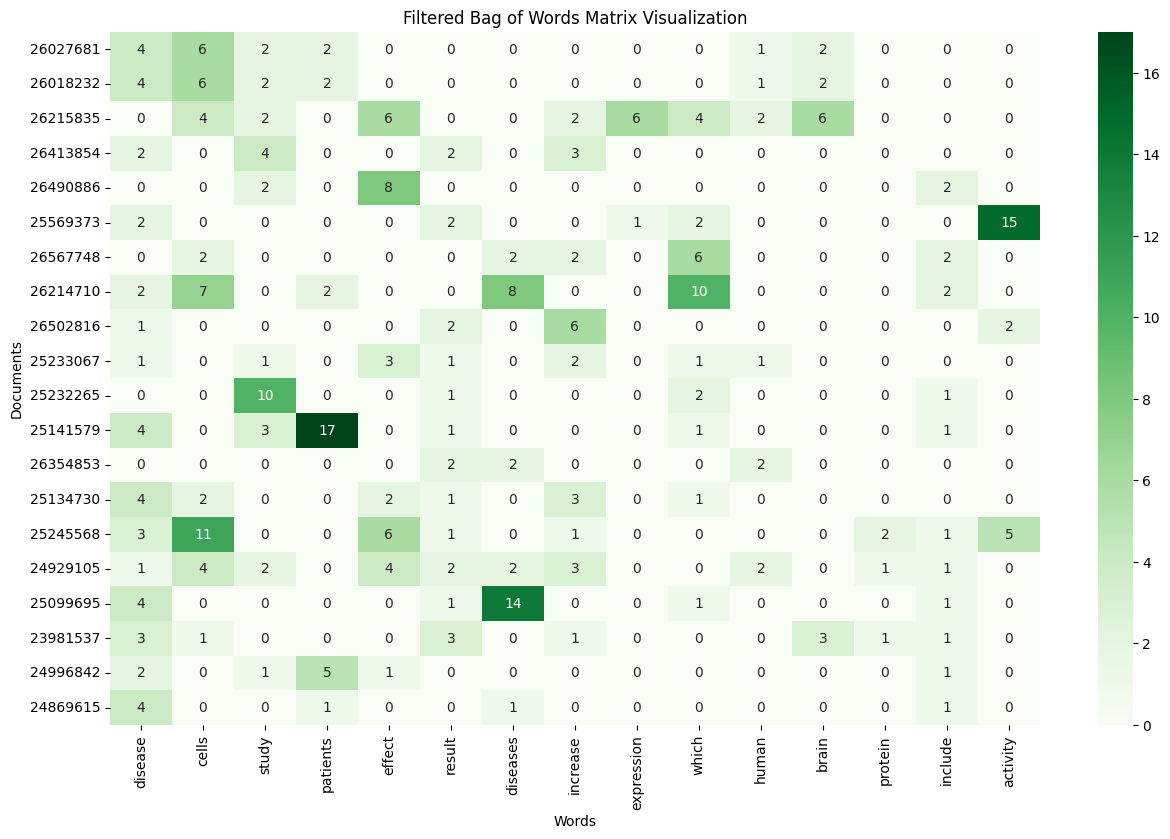

In [233]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered Bag of Words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

**Construct TF-IDF matrix from important words and n-grams**

The next script is designed to create a Term Frequency-Inverse Document Frequency (TF-IDF) matrix from a set of preprocessed documents and then refine this matrix by filtering out less relevant terms.

**Functionality**

1. *Creating the TF-IDF matrix*:<br>
   The script begins by generating a TF-IDF matrix using a list of preprocessed documents:
   - *TF-IDF matrix*: This matrix represents the importance of each word (or n-gram) across all documents in the corpus.
   - *`ngram_size`*: Specifies the size of word sequences to consider (e.g., unigrams, bigrams).
   - *`min_df`*: Filters out terms that appear in fewer than a specified number of documents, reducing noise in the analysis.

   This step is essential for transforming raw text data into a structured format that highlights important terms.

2. *Rearranging the TF-IDF matrix*:
   The script then refines the TF-IDF matrix by rearranging and filtering the terms:
   - *filtering*: The matrix is filtered based on criteria such as the importance of terms, ensuring that only the most relevant words remain.
   - *rearranging*: The matrix is reorganized according to a predefined order, based on the significance of terms or their relevance to specific documents.

   This refinement process is crucial for improving the quality of the analysis by focusing on the most impactful terms, which can lead to more accurate and insightful results.

**Use**

Users can apply this script as part of a larger text mining workflow where the TF-IDF matrix serves as an important step in structuring and analyzing the data. By filtering and refining the matrix, users can ensure that their analysis focuses on the most relevant and meaningful terms, leading to more meaningful insights. In the context of LBD, this script is an essential tool for turning raw text data into actionable insights.

In [234]:
# 1. Creating the TF-IDF matrix
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))

# 2. Rearranging the TF-IDF matrix
#    Rearange (filter) the TF-IDF matrix according to the previously computed order from bow matrix.
tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent n-grams: ', len(word_list))

Number of terms in initial vocabulary with all n-grams:  155490
Number of terms in preprocessed vocabulary after removing infrequent n-grams:  15274


**Compute margins for TF-IDF matrix**

This script is designed to analyze and manipulate Term Frequency-Inverse Document Frequency (TF-IDF) data for a corpus of documents. It computes various statistics related to the TF-IDF values for both words and documents, then filters the TF-IDF matrix to reorder it based on the most important words and documents.

**Functionality**

1. *Summing and maximizing TF-IDF values*:
   - `sum_count_each_word_in_all_documents`: calculates the sum of TF-IDF scores for each word across all documents, providing insight into the overall importance of words in the entire corpus
   - `max_tfidf_each_word_in_all_documents`: finds the maximum TF-IDF score for each word, indicating the document where each word is most important
   - `sum_count_all_words_in_each_document`: computes the sum of TF-IDF scores for all words in each document, which can be used to determine the "weight" or importance of the document itself
   - `max_tfidf_all_words_in_each_document`: identifies the highest TF-IDF score for each document, which can help isolate which document contains particularly important terms

2. *Output statistics*:
   - The script uses Python's `itertools.islice` function to print a preview of the top 7 values from each TF-IDF statistic. This offers a quick way to inspect the data without overwhelming the output with large lists.

3. *Sorting and filtering the TF-IDF matrix*:
   - After calculating the TF-IDF statistics, the script computes an ordering for the rows (documents) and columns (words) based on the maximum TF-IDF values. This ensures that the most important terms and documents are given priority in subsequent analyses.
   - The `filter_matrix` function then reorders the original TF-IDF matrix based on these computed rankings, allowing for a focused view of the most significant content in the corpus.

**Practical applications**

- *Document analysis and classification*: By identifying the most important terms and documents in a corpus, this technique can assist in classifying documents into relevant categories.
- *Term and key concept extraction*: Researchers can use the sum and max TF-IDF scores to isolate critical keywords that may represent novel concepts or ideas in the context of Literature-Based Discovery.
- *Summarization and information retrieval*: By filtering out less important words and documents, this script can help narrow down a large corpus to the most relevant data, making retrieval tasks more efficient.

**Use**

This script is a practical tool for analyzing TF-IDF data in text mining applications. By summing and maximizing TF-IDF scores for words and documents, users can highlight the most significant elements of their corpus. The filtered matrix provides a more focused view of the most important terms, which is highly useful in fields like Literature-Based Discovery and NLP.

In [235]:
# 1. Summing and maximizing TF-IDF values
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

# 2. Output statistics
print('Sum of TF-IDF for each word: ', dict(itertools.islice(sum_word_tfidf.items(), 7)))
print('Max of TF-IDF for each word: ', dict(itertools.islice(max_word_tfidf.items(), 7)))

print('Sum of TF-IDF for each document: ', dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print('Max of TF-IDF for each document: ', dict(itertools.islice(max_doc_tfidf.items(), 7)))

# 3. Sorting and filtering the TF-IDF matrix
#    Compute the order of rows (documents) and columns (words) in the tfidf matrix so that the most important words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

#    Rearange (filter) the TF-IDF matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

Sum of TF-IDF for each word:  {'0000the': 0.03131585577796436, '0001multivariate': 0.05178920826570667, '009015mugml': 0.0465261109157432, '023x105': 0.04135440740991562, '100000mm3': 0.040019721995073844, '100000year': 0.04940950154247733, '1000fold': 0.06397122586044375}
Max of TF-IDF for each word:  {'0000the': 0.03131585577796436, '0001multivariate': 0.05178920826570667, '009015mugml': 0.0465261109157432, '023x105': 0.04135440740991562, '100000mm3': 0.040019721995073844, '100000year': 0.04940950154247733, '1000fold': 0.06397122586044375}
Sum of TF-IDF for each document:  {'26578392': 5.893032502934008, '26575203': 3.284395753855353, '26574544': 5.057697129035433, '26567748': 6.630723872566392, '26560688': 4.401642342151689, '26560048': 4.609067219828064, '26548612': 3.5888128190679796}
Max of TF-IDF for each document:  {'26578392': 0.21088183077053105, '26575203': 0.2224231040166397, '26574544': 0.1782472202775803, '26567748': 0.13176229724719266, '26560688': 0.23669054252472027, '

**Visualize a part of TF-IDF matrix**

Visualize the upper left part of the TF-IDF matrix. In the TF-IDF matrix, each row corresponds to a document and each column to a word (or n-gram). The values in the matrix represent the Term Frequency Inverse Document Frequency (abbreviated TF-IDF) of the word (term) in the corresponding document and document corpus. TF-IDF is a measure of how relevant a word in a document is in relation to a corpus: the measure increases proportionally to the number of occurrences of a word in the text, but is compensated for by the word frequency in the entire corpus.

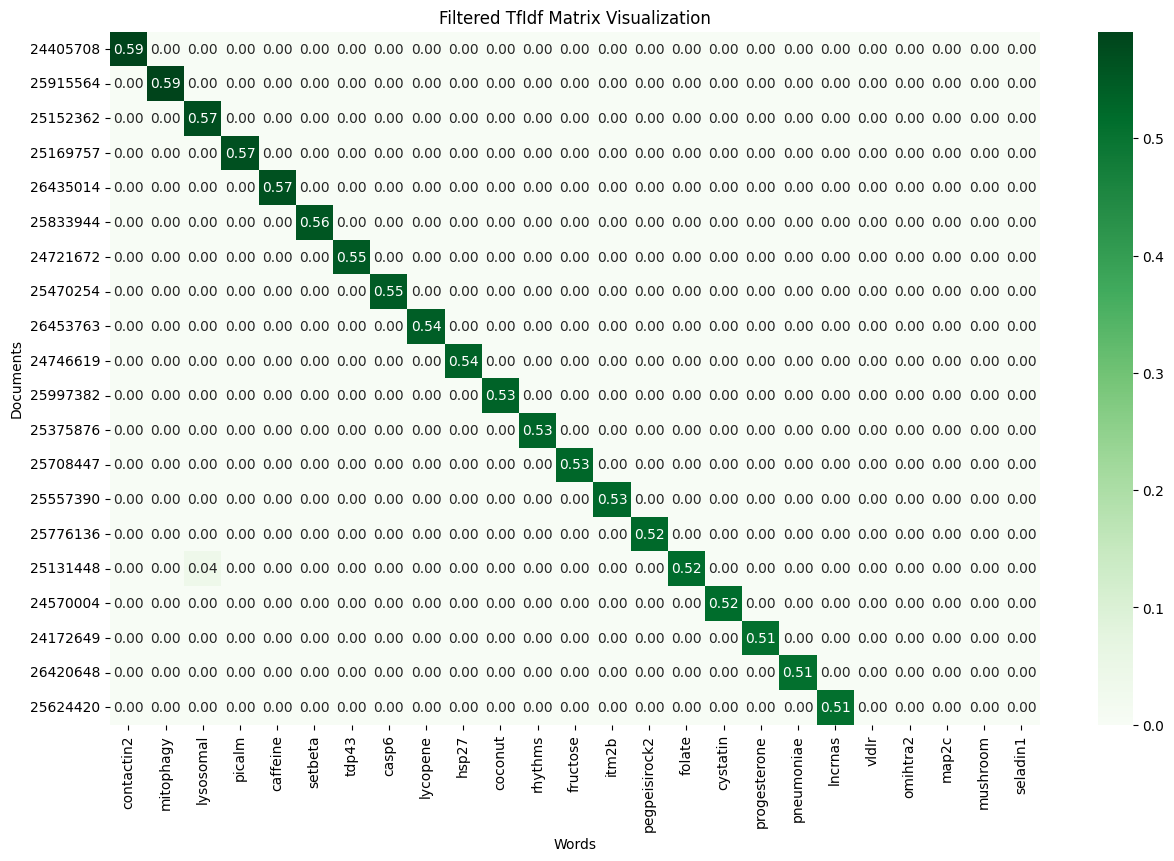

In [236]:
first_row = 0
last_row = 20
first_column = 0
last_column = 25
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TfIdf', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

Create a list of domain names of all documents (from the dictionary containing the documents) and a list of unique domain names. In the first context (CONTEXT_SWITCH = 1 or 2) there are two distinct domains: *Autism* and *Calcineurin*.

In [237]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(prep_docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('A list of all uniques domain names in all the documents: ', unique_domains_list)

Domain names for the first few documents:  ['Alzheimer', 'Alzheimer', 'Alzheimer', 'Alzheimer', 'Alzheimer', 'Alzheimer', 'Alzheimer']
A list of all uniques domain names in all the documents:  ['Alzheimer', 'GIMB']


Find outlier documents. Next, move the *find_document_outliers* function to LBD_04_text_mining.ipynb.

In [238]:
# Prepare a list of outlier documents based ob TF-IDF matrix; by the same token, a list of outlier words can be identified

# utility for finding outlier documents from TF-IDF matrix

def find_document_outliers(tfidf_matrix, n_outliers=1):
    """
    Identify outliers based on cosine distance from the centroid of all document vectors.
    
    Parameters:
    - tfidf_matrix: 2D numpy array of shape (n_docs, n_features), the TF-IDF matrix.
    - outlier_fraction: float, the fraction of documents to consider as outliers.
    
    Returns:
    - outlier_indices: List of indices of the documents identified as outliers.
    """
    
    # Step 1: Compute the centroid of the TF-IDF vectors
    centroid = np.mean(tfidf_matrix, axis=0)
    # print(centroid)
    
    # Step 2: Compute cosine distances between each document vector and the centroid
    # Since we are computing cosine distance from the centroid, reshape centroid to (1, -1)
    distances = cosine_distances(tfidf_matrix, centroid.reshape(1, -1)).flatten()
    # print(distances)
    
    # Step 3: Determine the number of outliers to select
    # n_docs = tfidf_matrix.shape[0]
    # n_outliers = int(np.ceil(outlier_fraction * n_docs))
    
    # Step 4: Find the indices of the top N documents with the highest distances
    if n_outliers < 0:
        outlier_indices = np.argsort(distances)[-n_outliers:]
    else:
        outlier_indices = np.argsort(distances)[-n_outliers:]
    
    return outlier_indices

# Example usage:
# Assuming tfidf_matrix is a numpy array of shape (n_docs, n_features) representing the TF-IDF matrix
# outliers = find_outliers(tfidf_matrix, outlier_fraction=0.1)
# print(outliers)  # List of indices of the 10% most outlier documents


# utility for finding outlier words from TF-IDF matrix

def find_word_outliers(tfidf_matrix, vocabulary, n_outliers=1):
    """
    Identify outlier words based on cosine distance from the centroid of all word vectors.
    
    Parameters:
    - tfidf_matrix: 2D numpy array of shape (n_docs, n_features), the TF-IDF matrix.
    - vocabulary: List of words corresponding to the columns (features) in the TF-IDF matrix.
    - outlier_fraction: float, the fraction of words to consider as outliers.
    
    Returns:
    - outlier_words: List of words identified as outliers.
    """
    
    # Step 1: Compute the centroid of the word vectors (columns)
    centroid = np.mean(tfidf_matrix, axis=1)  # Centroid of columns (words)
    # print(centroid)
    
    # Step 2: Compute cosine distances between each word vector and the centroid
    # Since we are calculating cosine distance for words (columns), we transpose the matrix
    distances = cosine_distances(tfidf_matrix.T, centroid.reshape(1, -1)).flatten()
    # print(distances)
    
    # Step 3: Determine the number of outlier words to select
    # n_words = tfidf_matrix.shape[1]
    # n_outliers = int(np.ceil(outlier_fraction * n_words))
    
    # Step 4: Find the indices of the top N words with the highest distances
    if n_outliers < 0:
        outlier_indices = np.argsort(distances)[:-n_outliers]
    else:
        outlier_indices = np.argsort(distances)[-n_outliers:]
    
    # Step 5: Retrieve the corresponding outlier words using the vocabulary
    outlier_words = [vocabulary[i] for i in outlier_indices]
    
    return outlier_words

# Example usage:
# Assuming tfidf_matrix is a numpy array of shape (n_docs, n_features) representing the TF-IDF matrix
# and vocabulary is a list of words corresponding to the columns of the TF-IDF matrix
# outliers = find_word_outliers(tfidf_matrix, vocabulary, outlier_fraction=0.1)
# print(outliers)  # List of 10% most outlier words

# prep_docs_list, ids_list, word_list, tfidf_matrix

print('Matrix rows, columns: ', tfidf_matrix.shape) # rows, columns
tfidf_matrix = np.asarray(tfidf_matrix)
# print(type(tfidf_matrix))

# Find outlier documents
outlier_docs = find_document_outliers(tfidf_matrix,  n_outliers=20)
print('Outlier docs indeces: ', outlier_docs) # list of documents is lines and preprocessed in prep_docs_list; ids_list contains document ids
outlier_docs_list = outlier_docs.astype(int).tolist()
print('Outlier docs ids: ', [ids_list[i] for i in outlier_docs_list])

# Find representative documents
representative_docs = find_document_outliers(tfidf_matrix,  n_outliers=-20)
print('Representative docs indeces: ', representative_docs) # list of documents is lines and preprocessed in prep_docs_list; ids_list contains document ids
representative_docs_list = representative_docs.astype(int).tolist()
print('Representative docs ids: ', [ids_list[i] for i in representative_docs_list])

# Find outlier words
outlier_words = find_word_outliers(tfidf_matrix, word_list,  n_outliers=20)
print('Outlier words: ', outlier_words)

# Find representative words
representative_words = find_word_outliers(tfidf_matrix, word_list,  n_outliers=-20)
print('Representative words: ', representative_words)


# Find again outlier documents, this time with the proper size for furter processing
outlier_docs = find_document_outliers(tfidf_matrix,  n_outliers=7000)
outlier_docs_list = outlier_docs.astype(int).tolist()



Matrix rows, columns:  (766, 15274)
Outlier docs indeces:  [328 199 482 437 160 152 467 593 504  51 436 255  85  67 122 479 439 555
 414  32]
Outlier docs ids:  ['25229860', '25661086', '24708721', '24889810', '25791048', '25831610', '24753468', '24309505', '24619869', '26331911', '24903697', '25492566', '26145695', '26221675', '25982958', '24717089', '24872596', '24429454', '24983592', '26418600']
Representative docs indeces:  [428 545  12 512 649 715 209 256 462 497 583 704  37 637  81 271 427 575
 459 596 302 765 349 119 444 617 614 630 696  93 374  97 624 503 251 289
  38  24 310 663 484 229 382 686 441 571 376 508 634 725 401 691 727 239
 357 751 706  15 128 343 276 483 755 694 115 361 159  71 736 201 341 597
 588 282 450 321 670 242 607 601 613 294 366 726  79 550 494 680 277 498
 419 676 367  77 753 604 268 312 718  56 284 700 656 752 724 184 326 626
 117 646 407 238 273 679  28 739 290 693  99 245 645 240 647 300 288 625
  57 445  52 451 232   3 394 448 759 369 628 266 431 299 

**Aggregating Bag-of-Words matrix by domain**

This script helps users aggregate a Bag-of-Words (BoW) matrix based on domain information, which collapses individual document representations into aggregated domain-level representations, allowing for easier analysis of textual data categorized by domains.

**Functionality**

This script processes a Bag-of-Words matrix (`bow_matrix`), grouping documents by their associated domain names from a `domains_list`. Each unique domain name in `unique_domains_list` will have all its corresponding documents' BoW vectors summed into a single domain-level vector. Here's a step-by-step breakdown:

1. *Create binary martix from BoW matrix*:  
   `binary_matrix = (bow_matrix > 0).astype(int)` creates binary matrix contaiong only 0 and 1 from the BoW matrix; the binary matrix is used to count number of documents that contain a word.

2. *Initialize empty matrix*:  
   `domains_bow_matrix = np.empty((0, bow_matrix.shape[1]))` initializes an empty matrix that will store the aggregated BoW vectors for each domain.

3. *Count documents per domain*:  
   The dictionary `no_documents_in_domain = {}` is created to track how many documents belong to each domain. This is useful for understanding the distribution of documents across domains.

4. *Iterate through domains*:  
   The script iterates over each unique domain in `unique_domains_list`. For each domain:
   - *Find domain documents*:  
     `domain_docs_indices` stores the indices of all documents in `domains_list` that belong to the current domain.
   - *Count and record document count*:  
     The length of `domain_docs_indices` is stored in the dictionary `no_documents_in_domain[domain_name]`.
   - *Aggregate BoW vectors*:  
     Using the document indices, the script selects the corresponding rows from `bow_matrix`, sums them (`tmp = (bow_matrix[domain_docs_indices,:]).sum(axis=0)`), and appends the result to `domains_bow_matrix`.

5. *Output*:  
   After processing all domains, the script prints two outputs:
   - `domains_bow_matrix`: The BoW matrix, now aggregated by domains.
   - `no_documents_in_domain`: A dictionary showing how many documents were grouped under each domain.

**Practical Applications**

This script is highly useful in various NLP and text mining fields, particularly when dealing with large collections of text that can be grouped into domains or categories:

- *Biomedical research and discovery*: Researchers can use the aggregated domain-level BoW vectors to study relationships between different knowledge domains and detect novel hypotheses or cross-disciplinary insights.
- *Topic modeling and clustering*: Aggregating BoW vectors by domain enables better analysis of domain-specific topics, which could be useful in extracting themes from large bodies of literature. Grouping documents by domain can facilitate clustering, allowing users to investigate how text clusters vary across different domains.

**Use**

To use this script:
1. *Prepare Input*: Ensure you have a Bag-of-Words matrix (`bow_matrix`), where each row represents a document's word vector. You also need a list of domains (`domains_list`) with the same length as the number of documents, and a list of unique domain names (`unique_domains_list`).
2. *Run the Script*: Execute the script in a Python environment (after importing `numpy` as `np`), and it will return two key outputs:
   - `domains_bow_matrix`: The BoW vectors aggregated by domain.
   - `no_documents_in_domain`: The count of documents per domain.
   
These outputs can be used in further analysis, such as domain-specific topic modeling, clustering, or visualization tasks. 

In [239]:
# 1. Create binary martix from BoW matrix 
binary_matrix = (bow_matrix > 0).astype(int)

# 2. Initialize empty matrices
domains_bow_matrix = np.empty((0, bow_matrix.shape[1]))
domains_binary_matrix = np.empty((0, binary_matrix.shape[1]))

domains_outlier_bow_matrix = np.empty((0, bow_matrix.shape[1]))
domains_outlier_binary_matrix = np.empty((0, binary_matrix.shape[1]))

domains_sum_tfidf_matrix = np.empty((0, tfidf_matrix.shape[1]))
domains_max_tfidf_matrix = np.empty((0, tfidf_matrix.shape[1]))

domains_outlier_sum_tfidf_matrix = np.empty((0, tfidf_matrix.shape[1]))
domains_outlier_max_tfidf_matrix = np.empty((0, tfidf_matrix.shape[1]))

# 3. Count documents per domain
no_documents_in_domain = {}
no_outlier_documents_in_domain = {}

# 4. Iterate through domains
for i, domain_name in enumerate(unique_domains_list):
    domain_docs_indices = [i for i, label in enumerate(domains_list) if label == domain_name]
    no_documents_in_domain[domain_name] = len(domain_docs_indices)

    domain_outlier_docs_indices = [i for i, label in enumerate(domains_list) if (label == domain_name) and (i in outlier_docs)]
    no_outlier_documents_in_domain[domain_name] = len(domain_outlier_docs_indices)

    tmp0 = (bow_matrix[domain_docs_indices,:]).sum(axis=0)
    domains_bow_matrix = np.vstack((domains_bow_matrix, tmp0))

    tmp1 = (binary_matrix[domain_docs_indices,:]).sum(axis=0)
    domains_binary_matrix = np.vstack((domains_binary_matrix, tmp1))

    tmp2 = (bow_matrix[domain_outlier_docs_indices,:]).sum(axis=0)
    domains_outlier_bow_matrix = np.vstack((domains_outlier_bow_matrix, tmp2))

    tmp3 = (binary_matrix[domain_outlier_docs_indices,:]).sum(axis=0)
    domains_outlier_binary_matrix = np.vstack((domains_outlier_binary_matrix, tmp3))


    tmp4 = (tfidf_matrix[domain_docs_indices,:]).sum(axis=0)
    domains_sum_tfidf_matrix = np.vstack((domains_sum_tfidf_matrix, tmp4))

    tmp5 = (tfidf_matrix[domain_docs_indices,:]).max(axis=0)
    domains_max_tfidf_matrix = np.vstack((domains_max_tfidf_matrix, tmp5))

    tmp6 = (tfidf_matrix[domain_outlier_docs_indices,:]).sum(axis=0)
    domains_outlier_sum_tfidf_matrix = np.vstack((domains_outlier_sum_tfidf_matrix, tmp6))

    tmp7 = (tfidf_matrix[domain_outlier_docs_indices,:]).max(axis=0)
    domains_outlier_max_tfidf_matrix = np.vstack((domains_outlier_max_tfidf_matrix, tmp7))

# 5. Output
print('Aggregated BoW matrix for the domains:')
print(domains_bow_matrix)
print('Aggregated binary matrix for the domains:')
print(domains_binary_matrix)
print('Aggregated outliers BoW matrix for the domains:')
print(domains_outlier_bow_matrix)
print('Aggregated outliers binary matrix for the domains:')
print(domains_outlier_binary_matrix)
print()
print('Aggregated sum TF-IDF matrix for the domains:')
print(domains_sum_tfidf_matrix)
print('Aggregated max TF-IDF matrix for the domains:')
print(domains_max_tfidf_matrix)
print('Aggregated outliers sum TF-IDF matrix for the domains:')
print(domains_outlier_sum_tfidf_matrix)
print('Aggregated outliers max TF-IDF matrix for the domains:')
print(domains_outlier_max_tfidf_matrix)
print()
print('Number of documents in each domain: ', no_documents_in_domain)
print('Number of outlier documents in each domain: ', no_outlier_documents_in_domain)

Aggregated BoW matrix for the domains:
[[0. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 0. 0. 0.]]
Aggregated binary matrix for the domains:
[[0. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 0. 0. 0.]]
Aggregated outliers BoW matrix for the domains:
[[0. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 0. 0. 0.]]
Aggregated outliers binary matrix for the domains:
[[0. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 0. 0. 0.]]

Aggregated sum TF-IDF matrix for the domains:
[[0.         0.         0.04652611 ... 0.04399054 0.05452788 0.05432076]
 [0.03131586 0.05178921 0.         ... 0.         0.         0.        ]]
Aggregated max TF-IDF matrix for the domains:
[[0.         0.         0.04652611 ... 0.04399054 0.05452788 0.05432076]
 [0.03131586 0.05178921 0.         ... 0.         0.         0.        ]]
Aggregated outliers sum TF-IDF matrix for the domains:
[[0.         0.         0.04652611 ... 0.04399054 0.05452788 0.05432076]
 [0.03131586 0.05178921 0.         ... 0.         0.         0.        ]]
Aggregated outliers max TF-

We have created eight matrices that have two rows (one for each domain) and *len(word_list)* columns (one for each word in the vocabulary):

1. domains_bow_matrix: frequency of words in domains (domain documents)
2. domains_binary_matrix: frequency of documents containing word in domains (each word is counted as 1 if present in a docuemnt)
3. domains_outlier_bow_matrix: in outlier documents only, frequency of words in domains (domain documents)
4. domains_outlier_binary_matrix: in outlier documents only, frequency of documents containing word in domains
5. domains_sum_tfidf_matrix: for each word, sum of TF-IDFs in domains 
6. domains_max_tfidf_matrix: for each word, max of TF-IDFs in domains
7. domains_outlier_sum_tfidf_matrix: in outlier documents only, for each word, sum of TF-IDFs in domains
8. domains_outlier_max_tfidf_matrix: in outlier documents only, for each word, max of TF-IDFs in domains

These matrices are used to compute heuristics defined in the following cells.


**Retrieving word frequency for a specific domain in a matrix**

This function, `cell_value_in_a_matrix()`, allows users to easily extract the frequency of a specific word within a particular domain from an aggregated matrix (BoW or TF-IDF). 

**Functionality**

The `cell_value_in_a_matrix()` function takes three inputs:
1. `a_matrix`: The Bag-of-Words matrix where rows correspond to unique domains, and columns correspond to words.
2. `domain_name`: The name of the domain for which the user wants to retrieve the word frequency.
3. `word`: The specific word for which the user wants to check its frequency in the given domain.

Here’s how the function works step-by-step:

1. *Locate Domain Index*:  
   `line_idx = unique_domains_list.index(domain_name)`  
   This line finds the index of the domain name in the `unique_domains_list`, which corresponds to the row in the `bow_matrix`.

2. *Locate Word Index*:  
   `column_idx = word_list.index(word)`  
   Similarly, this line retrieves the index of the word from `word_list`, representing the column in the BoW matrix.

3. *Return Word Frequency*:  
   `return(a_matrix[line_idx, column_idx])`  
   The function then returns the value from the BoW matrix at the specified row (domain) and column (word), which represents how many times the word appears in the documents grouped under that domain.

**Practical applications**

This function is useful in various NLP and text mining tasks, especially for domain-specific text analysis:

- *Biomedical research and discovery*: By retrieving the frequency of specific words across different domains, researchers can identify domain-specific terminology or emerging trends in literature.
- *Word frequency analysis*: Users can easily extract how often a particular word is used in different domains, which can help in understanding language patterns or keyword presence across domains.

**Use**

To use this function:
1. *Prepare Input*: Ensure you have the following inputs ready:
   - `a_matrix`: The Bag-of-Words or TF-IDF matrix, where rows represent domains, and columns represent words.
   - `unique_domains_list`: A list of unique domain names corresponding to the rows of the BoW matrix.
   - `word_list`: A list of all words corresponding to the columns of the BoW matrix.
   
2. *Call the Function*:  
   For example, to find how often the word `"vcfs"` appears in the domain `"Autism"`, call:
   ```python
   frequency = cell_value_in_a_matrix(bow_matrix, "Autism", "vcfs")
   print(frequency)
   ```

The output will be the frequency of the word "vcfs" in the `"Autism"` domain, based on the aggregated data in the `bow_matrix`.

In [240]:
def cell_value_in_a_matrix(a_matrix: np.ndarray, domain_name: str, word: str) -> float:
    """
    This function extracts the frequency of a specific word within a particular domain from an aggregated Bag-of-Words (BoW) matrix. 
    The `cell_value_in_a_matrix()` function takes three inputs:
        a_matrix: the Bag-of-Words or TF-IDF matrix where rows correspond to unique domains, and columns correspond to words
        domain_name: the name of the domain for which the user wants to retrieve the word frequency
        word: the specific word for which the user wants to check its frequency in the given domain
    """
    line_idx = unique_domains_list.index(domain_name)
    if word in word_list:
        column_idx = word_list.index(word)
        return(a_matrix[line_idx, column_idx])
    else:
        return(0.0)

print('Frequency of calmodulin in Autism: ', cell_value_in_a_matrix(domains_bow_matrix, 'Autism', 'calmodulin'))
print('Frequency of calmodulin in Calcineurin: ', cell_value_in_a_matrix(domains_bow_matrix, 'Calcineurin', 'calmodulin'))

print('Number of documents that contain calmodulin in Autism: ', cell_value_in_a_matrix(domains_binary_matrix, 'Autism', 'calmodulin'))
print('Number of documents that contain calmodulin in Calcineurin: ', cell_value_in_a_matrix(domains_binary_matrix, 'Calcineurin', 'calmodulin'))

print()

print('Frequency of vcfs in Autism: ', cell_value_in_a_matrix(domains_bow_matrix, 'Autism', 'vcfs'))
print('Frequency of vcfs in Calcineurin: ', cell_value_in_a_matrix(domains_bow_matrix, 'Calcineurin', 'vcfs'))

print('Number of documents that contain vcfs in Autism: ', cell_value_in_a_matrix(domains_binary_matrix, 'Autism', 'vcfs'))
print('Number of documents that contain vcfs in Calcineurin: ', cell_value_in_a_matrix(domains_binary_matrix, 'Calcineurin', 'vcfs'))

ValueError: 'Autism' is not in list

In [241]:
print(len(word_list))
print(word_list)

15274
['0000the', '0001multivariate', '009015mugml', '023x105', '100000mm3', '100000year', '1000fold', '1000mul', '1008mmaa', '100mumol', '101000mum', '1014chlorobenzyl1h123triazol4ylmethyl2methoxyacridin910hone', '10403mm', '106along', '10day', '10fold', '10kda', '10mgkgd1', '10mgkgday', '10mumoll', '10sup8sup10sup6sup', '111e2', '111inpn', '116mugg', '11cco2', '11cmethyl', '11cpbb3', '11diphenyl2picrylhydraxyl', '11diphenyl2picrylhydrazyl', '1201mm', '123triazole', '125ihplc', '12benzothiazolyl3hydroxy2methyl41hpyridinone', '12item', '12myristate', '12week', '131mugml', '137trimethylxanthine', '13acetate', '13c3labeled', '13ccarbon', '13cisotope', '13dipolar', '13ene26dione', '140min', '144033x104', '14aminophenyl3hydroxy2methyl41hpyridinone', '14beta', '14diazines', '14fold', '14monthold', '14q3231', '14weekold', '14yearsold', '1500mul', '156012x103', '15bed', '15day', '15fold', '15lipoxygenase', '15lox', '15nlabeled', '15q133', '16carbon', '1704gt', '170nm', '17p133', '17vamp8snap2

Now we have the aggregated BoW matrix `domains_bow_matrix` and the aggregated `domains_binary_matrix`. The rows of these matrices correspond to the domains (*Autism*, *Calcineurin*) and the columns correspond to the words from the vocabulary.

In the `domains_bow_matrix` the frequencies of the individual words are summed up, indicating how often the word occurs in the domain documents, while in the `domains_binary_matrix` the number of domain documents in which the word occurs is indicated (each word in a document counts as 1, even if it occurs many times in the document).

In [242]:
# define heuristics and then move them in LBD_04_text_mining.ipynb
# define ensemble framework and move it to the same file

def freqTerm(t: str) -> float:
    return cell_value_in_a_matrix(domains_bow_matrix, unique_domains_list[0], t) + cell_value_in_a_matrix(domains_bow_matrix, unique_domains_list[1], t)

print('1 freqTerm:', freqTerm('calmodulin'), freqTerm('vcfs'))
print()

def freqDoc(t: str) -> float:
    return cell_value_in_a_matrix(domains_binary_matrix, unique_domains_list[0], t) + cell_value_in_a_matrix(domains_binary_matrix, unique_domains_list[1], t)

print('2 freqDoc:', freqDoc('calmodulin'), freqDoc('vcfs'))
print()

def freqRatio(t: str) -> float:
    if freqDoc(t) > 0:
        return freqTerm(t) / freqDoc(t)
    else:
        return 0.0

print('3 freqRatio:', freqRatio('calmodulin'), freqRatio('vcfs'))
print()

def tfidfSum(t: str) -> float:
    if t in word_list:
        return sum_word_tfidf[t]
    else:
        return 0.0

print('4 tfidfSum:', tfidfSum('calmodulin'), tfidfSum('vcfs'))
print()

def tfidfMax(t: str) -> float:
    if t in word_list:
        return max_word_tfidf[t]
    else:
        return 0.0

print('5 tfidfMax:', tfidfMax('calmodulin'), tfidfMax('vcfs'))
print()

def out_freqTerm(t: str) -> float:
    return cell_value_in_a_matrix(domains_outlier_bow_matrix, unique_domains_list[0], t) + cell_value_in_a_matrix(domains_outlier_bow_matrix, unique_domains_list[1], t)

print('6 out_freqTerm:', out_freqTerm('calmodulin'), out_freqTerm('vcfs'))
print()

def out_freqDoc(t: str) -> float:
    return cell_value_in_a_matrix(domains_outlier_binary_matrix, unique_domains_list[0], t) + cell_value_in_a_matrix(domains_outlier_binary_matrix, unique_domains_list[1], t)

print('7 out_freqDoc:', out_freqDoc('calmodulin'), out_freqDoc('vcfs'))
print()

def out_freqRatio(t: str) -> float:
    if out_freqDoc(t) > 0:
        return out_freqTerm(t) / out_freqDoc(t)
    else:
        return 0.0

print('8 out_freqRatio:', out_freqRatio('calmodulin'), out_freqRatio('vcfs'))
print()

def out_tfidfSum(t: str) -> float:
    return cell_value_in_a_matrix(domains_outlier_sum_tfidf_matrix, unique_domains_list[0], t) + cell_value_in_a_matrix(domains_outlier_sum_tfidf_matrix, unique_domains_list[1], t)

print('9 out_tfidfSum:', out_tfidfSum('calmodulin'), out_tfidfSum('vcfs'))
print()

def out_tfidfMax(t: str) -> float:
    return max(cell_value_in_a_matrix(domains_outlier_max_tfidf_matrix, unique_domains_list[0], t), cell_value_in_a_matrix(domains_outlier_max_tfidf_matrix, unique_domains_list[1], t))

print('10 out_tfidfMax:', out_tfidfMax('calmodulin'), out_tfidfMax('vcfs'))
print()

1 freqTerm: 0.0 0.0

2 freqDoc: 0.0 0.0

3 freqRatio: 0.0 0.0

4 tfidfSum: 0.0 0.0

5 tfidfMax: 0.0 0.0

6 out_freqTerm: 0.0 0.0

7 out_freqDoc: 0.0 0.0

8 out_freqRatio: 0.0 0.0

9 out_tfidfSum: 0.0 0.0

10 out_tfidfMax: 0.0 0.0



We have defined ten functions that compute heuristic scores of a given word from the vocabulary:

1. freqTerm: 
2. freqDoc: 
3. freqRatio: 
4. tfidfSum: 
5. tfidfMax: 
6. out_freqTerm: 
7. out_freqDoc: 
8. out_freqRatio: 
9. out_tfidfSum: 
10. out_tfidfMax: 

These scores can be used as an estimations of the potential of b-term candidates.

In [243]:
# Input: domains_list, outlier_docs_list 
from collections import Counter

# 1: count occurrences of domain names in the first list
domains_counts = Counter(domains_list)

# 2: filter the list using the selected indices
filtered_list = [domains_list[i] for i in outlier_docs_list]

# 3: count occurrences of domain names in the filtered list
filtered_counts = Counter(filtered_list)

# Output the results
print(f"Count in original list: {domains_counts}")
print(f"Count in filtered list: {filtered_counts}")

Count in original list: Counter({'Alzheimer': 644, 'GIMB': 122})
Count in filtered list: Counter({'Alzheimer': 644, 'GIMB': 122})


In [244]:
# Populate dictionaries for various heuristics

import random
import time

# Seed the random number generator for repeated randomness
random.seed(321)

# Generate a random 7-digit number
random_number = random.randint(1000000, 9999999)

print("Dictionary of words, count and max(tfidf) ...")

selected_freqTerm = {}
selected_freqDoc = {}
selected_freqRatio = {}
selected_tfidfSum = {}
selected_tfidfMax = {}

max_word_tfidf_selected = {}
sum_word_tfidf_selected = {} 
aux_word_tfidf_selected = {} 
min_word_tfidf_selected = {} ### TODO from here on ...
for word in max_word_tfidf.keys():
    if sum_count_docs_containing_word[word] >= 1: # the word should appear in at least n documents, n = 1
        passed = True
        for domain_name in unique_domains_list:
            if cell_value_in_a_matrix(domains_bow_matrix, domain_name, word) <= 0: # the word should appear at least once in each domain
                passed = False
        if passed:
            # max_word_tfidf_selected[word] = max_word_tfidf[word]
            sum_word_tfidf_selected[word] = sum_word_tfidf[word]
            aux_word_tfidf_selected[word] = random.randint(1, 999999)
            min_word_tfidf_selected[word] = max_word_tfidf[word] * sum_word_tfidf[word]

            max_word_tfidf_selected[word] = max_word_tfidf[word] # out_freqRatio(word)

            selected_freqTerm[word] = freqTerm(word)
            selected_freqDoc[word] = freqDoc(word)
            selected_freqRatio[word] = freqRatio(word)
            selected_tfidfSum[word] = tfidfSum(word)
            selected_tfidfMax[word] = tfidfMax(word)

            # def freqTerm(t: str) -> float:
            # def freqDoc(t: str) -> float:
            # def freqRatio(t: str) -> float:
            # def tfidfSum(t: str) -> float:
            # def tfidfMax(t: str) -> float:
            # def out_freqTerm(t: str) -> float:
            # def out_freqDoc(t: str) -> float:
            # def out_freqRatio(t: str) -> float:
            # def out_tfidfSum(t: str) -> float:
            # def out_tfidfMax(t: str) -> float:

# print(tfidfMax('vcfs'))

# max_word_tfidf_selected = aux_word_tfidf_selected
# max_word_tfidf_selected = sum_word_tfidf_selected
# max_word_tfidf_selected = min_word_tfidf_selected

Dictionary of words, count and max(tfidf) ...


In [255]:
max_word_tfidf_selected = selected_tfidfSum

import itertools
print('All the words in the vocabulary: ', len(max_word_tfidf))
print('Selected b-term candidate words: ', len(max_word_tfidf_selected), ' ', dict(itertools.islice(max_word_tfidf_selected.items(), 30)))

max_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf_selected, True)

print('Sorted b-term candidate words: ', len(max_word_tfidf_selected_sorted), ' ', dict(itertools.islice(max_word_tfidf_selected_sorted.items(), 30)))
print('The first and the last sorted b-term word: ', list(max_word_tfidf_selected_sorted.items())[0], ' ', list(max_word_tfidf_selected_sorted.items())[-1])
print('Mean value of max TF-IDF values: ', np.array(list(max_word_tfidf_selected_sorted.values())).mean())

All the words in the vocabulary:  15274
Selected b-term candidate words:  2920   {'1980s': 0.09949473511852142, '21days': 0.08941436127135795, '5year': 0.4049543229785445, 'aberrations': 0.25530145532351156, 'abilities': 0.22595493974331635, 'ability': 1.324839642306342, 'ablation': 0.22069085103056812, 'abnormal': 1.0367103330677871, 'abnormalities': 0.38300944132653436, 'abolish': 0.2718555479744976, 'absence': 0.8375716251092741, 'absent': 0.11923260706965896, 'absorption': 0.414370118668838, 'abundance': 0.38292845952305044, 'accept': 0.24124982222164315, 'access': 0.884590742340919, 'accompany': 0.3349862615628154, 'accord': 0.7630622489550052, 'account': 0.6360863648275327, 'accumulate': 0.6229983913714026, 'accumulate evidence': 0.21157057036440188, 'accumulation': 1.2208634555747504, 'accuracy': 0.3734192708688846, 'accurate': 0.3437475116529604, 'accurately': 0.1337942739137346, 'acetylcholinesterase': 1.5016683395470225, 'achieve': 1.3006793253476738, 'acids': 2.4348144022766

In [256]:
max_word_tfidf_selected_sorted

{'cells': 11.505482547564501,
 'patients': 11.052819121162656,
 'disease': 10.37643949419901,
 'study': 8.76179728122658,
 'diseases': 8.005747318122978,
 'effect': 7.658697786686969,
 'expression': 7.510829626897239,
 'human': 6.920696698305445,
 'brain': 6.882690818408486,
 'increase': 6.393316776599983,
 'protein': 6.3764108308450185,
 'activity': 6.143803328507806,
 'result': 6.05157757732785,
 'which': 5.8981109834786904,
 'include': 5.624032808817241,
 'level': 5.526277980062726,
 'alzheimers': 5.494764002315006,
 'signal': 5.482106559518565,
 'function': 5.278937023734369,
 'associate': 5.159066970744709,
 'alzheimers disease': 5.088994813283004,
 'cancer': 5.0373204820019435,
 'treatment': 5.000578534464777,
 'group': 4.925367044367479,
 'disorder': 4.893191833280733,
 'factor': 4.86952157758128,
 'model': 4.822757945973067,
 'review': 4.792924104547856,
 'clinical': 4.7533676289864975,
 'proteins': 4.61998799029231,
 'control': 4.409207381192937,
 'potential': 4.38429296761777

In [257]:
bterms_list = list(max_word_tfidf_selected_sorted.keys())
bterms_list_length = len(bterms_list)

df = pd.DataFrame({'b-term': bterms_list, 'max TF-IDF': list(max_word_tfidf_selected_sorted.values())})
df[0:45]

,b-term,max TF-IDF
0,cells,11.505483
1,patients,11.052819
2,disease,10.376439
3,study,8.761797
4,diseases,8.005747
5,effect,7.658698
6,expression,7.510830
7,human,6.920697
8,brain,6.882691
9,increase,6.393317


In [258]:
name = 'bcl2'
if name in list(max_word_tfidf_selected_sorted.keys()):
    print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
          '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

In [259]:
name = 'nitric'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

nitric: position in the list of rare terms 832 (2920), max tfidf: 0.641


In [260]:
name = 'nitric oxide'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

nitric oxide: position in the list of rare terms 833 (2920), max tfidf: 0.641


In [261]:
name = 'nitric oxide synthase'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

nitric oxide synthase: position in the list of rare terms 1570 (2920), max tfidf: 0.293


In [262]:
petric_bterms = ["22q112", "deletion syndrome", "asbestos", "bcl2", "bombesin", "calmodulin", "radiation", \
                 "hypothyroxinemia", "synaptic", "synaptic plasticity", "type 1 diabetes", \
                 "ulcerative colitis", "working memory", \
                 "t17p22q21"]

petric_bterms = ["22q112", "deletion", "syndrome", "asbestos", "bcl2", "bombesin", "calmodulin", "radiation", \
                 "hypothyroxinemia", "synaptic", "plasticity", "diabetes", \
                 "ulcerative", "colitis", "work", "memory", "t17p22q21"] # single

petric_bterms = ["22q112", "deletion syndrome", "asbestos", "bcl2", "bombesin", "calmodulin", "radiation", \
                 "hypothyroxinemia", "synaptic", "synaptic plasticity", "diabetes", \
                 "ulcerative colitis", "work memory", "t17p22q21"] # n-terms

petric_bterms = ["synaptic", "synaptic plasticity", "calmodulin", "radiation", "working memory", 
                 "bcl 2", "type 1 diabetes", "ulcerative colitis", "asbestos", "deletion syndrome", 
                 "22q11 2", "maternal hypothyroxinemia", "bombesin"]

petric_bterms = ["synaptic", "synaptic plasticity", "calmodulin", "radiation", "memory", 
                 "bcl2", "diabetes", "ulcerative colitis", "asbestos", "deletion syndrome", 
                 "22q112", "maternal hypothyroxinemia", "bombesin"]

petric_bterms = ["5ht", "5hydroxytryptamine", "5hydroxytryptamine receptors", "aggregation", "inflammatory", \
                   "anticonvulsant", "antimigraine", "arterial spasms", "brain serotonin", "calcium antagonist", "calcium blockers", \
                   "calcium channel", "calcium channel blockers", "cerebral vasospasm", "convulsions", "convulsive", "coronary spasm", \
                   "cortical spread depression", "diltiazem", "epilepsy", "epileptic", "epileptiform", "hypoxia", "indomethacin", \
                   "inflammatory", "nifedipine", "paroxysmal", "platelet aggregation", "platelet function", "prostacyclin", \
                   "prostaglandin", "prostaglandin e1", "prostaglandin synthesis", "reactivity", "seizure", "serotonin", \
                   "spasm", "spread", "spread depression", "stress", "substancep", "vasospasm", "verapamil"]

petric_bterms = ["nitric", "nitric oxide", "nitric oxide synthase"]
nn = 0
indb = []
size = len(max_word_tfidf_selected_sorted)
for name in petric_bterms:
    if name in max_word_tfidf_selected_sorted.keys():
       nn += 1
       position = list(max_word_tfidf_selected_sorted.keys()).index(name)
       indb.append(position)
       print(name, ': ', 'position in the list of potential bterms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
             '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), ' part: ', format(position/size*100, '.1f'), sep='')
    else:
        print('NOT:', name, 'NOT in the list.')   
print(nn, len(petric_bterms))
mm = len(petric_bterms)
print(indb)

nitric: position in the list of potential bterms 832 (2920), max tfidf: 0.641 part: 28.5
nitric oxide: position in the list of potential bterms 833 (2920), max tfidf: 0.641 part: 28.5
nitric oxide synthase: position in the list of potential bterms 1570 (2920), max tfidf: 0.293 part: 53.8
3 3
[832, 833, 1570]


Changed b-terms:

- working memory -> memory
- type 1 diabetes -> diabetes

Missing b-terms:

- 5hydroxytryptamine receptors - found only in Migraine !Mig documents
- antimigraine - found only in Migraine !Mig documents

TODO: implement selected heuristics for bterm ranking

In [263]:
print(f'Size: {size}')
print(f'len(indb): {len(indb)}')
print()

pt = []
for i in range(size):
    pt.append(0)
for i in range(len(indb)):
    for j in range(indb[i], size):
        pt[j] += 1
print(pt)
suma = 0
part = 0
for i in range(size):
    if i % 100 == 0:
        # print((i+1)/size*100.0, pt[i]/len(indb)*100.0)
        print((i+1)/size*100.0, pt[i]/mm*100.0)
    part += pt[i]
    suma += len(indb)
print(part/suma*100.0)

no_all_bterm_candidates = size
no_swansons_bterms = mm # len(indb)

Size: 2920
len(indb): 3

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

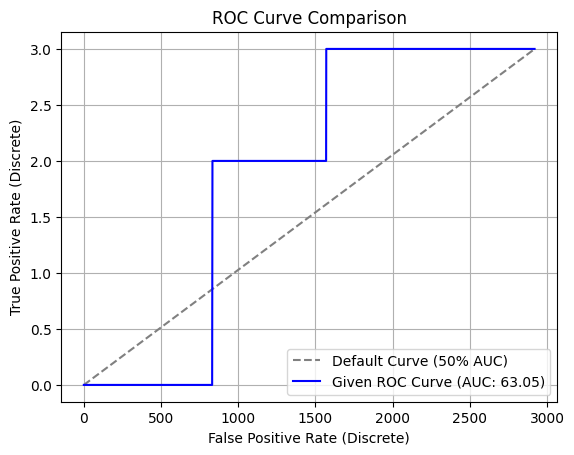

In [264]:
import matplotlib.pyplot as plt
import numpy as np

# Example ROC curve points (y-values), replace with the actual list of 120 numbers
roc_points = pt

# X-values for the ROC curve (0 to 120)
x_values = np.arange(0, no_all_bterm_candidates)

# Calculating the AUC for the given ROC curve using the trapezoidal rule
auc = np.trapz(roc_points, x_values) / (no_all_bterm_candidates*no_swansons_bterms) * 100  # Normalizing by the area of the full plot

# Plotting the default curve (50% AUC)
default_x = np.array([0, no_all_bterm_candidates])
default_y = np.array([0, no_swansons_bterms])
plt.plot(default_x, default_y, label='Default Curve (50% AUC)', linestyle='--', color='gray')

# Plotting the given ROC curve
plt.plot(x_values, roc_points, label=f'Given ROC Curve (AUC: {auc:.2f})', color='blue')

# Adding labels and legend
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (Discrete)')
plt.ylabel('True Positive Rate (Discrete)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [265]:
print(len(x_values))
print(len(roc_points))

# x_values -> roc_points (y_values)
# len_x_values, len_roc_points (len_y_values)
# actual values: x_values/len_x_values, y_values / len_y_values




2920
2920


Certainly! To display a table with the words and the votes from each function in separate columns, we can use the `pandas` library. Here’s how you can modify the previous code to achieve that:

```python
import pandas as pd
from typing import Callable, List

def voting_framework(words: List[str], voting_functions: List[Callable[[str], bool]], num_functions_to_select: int) -> pd.DataFrame:
    # Select a subset of functions from the pool (e.g., the first num_functions_to_select functions)
    selected_functions = voting_functions[:num_functions_to_select]
    
    # Initialize a dictionary to store the voting results for each word
    vote_results = {word: [] for word in words}
    
    # Apply each selected function to every word and store the results
    for word in words:
        for func in selected_functions:
            vote_results[word].append(func(word))
    
    # Convert the results to a DataFrame for better visualization
    df = pd.DataFrame(vote_results).T  # Transpose to have words as rows
    df.columns = [f"Function {i+1}" for i in range(num_functions_to_select)]
    
    # Add a column for the total number of votes (summing the True values)
    df['Total Votes'] = df.sum(axis=1)
    
    # Sort the DataFrame by the total number of votes, from max to min
    df = df.sort_values(by='Total Votes', ascending=False)
    
    return df

# Example voting functions
def is_vowel_start(word: str) -> bool:
    return word[0].lower() in 'aeiou'

def is_long_word(word: str) -> bool:
    return len(word) > 5

def contains_z(word: str) -> bool:
    return 'z' in word.lower()

def ends_with_y(word: str) -> bool:
    return word[-1].lower() == 'y'

# Example usage
words = ["apple", "zebra", "yellow", "banana", "xylophone", "umbrella", "kitty"]
voting_functions = [is_vowel_start, is_long_word, contains_z, ends_with_y]

# Select 3 out of 4 functions to vote
df = voting_framework(words, voting_functions, num_functions_to_select=3)

# Display the DataFrame
print("Voting Results Table:")
print(df)
```

### Explanation:
1. **Data Structure**: The voting results for each word are stored in a dictionary, where the key is the word and the value is a list of votes (boolean values) from each selected function.

2. **Pandas DataFrame**: The results are converted into a `pandas` DataFrame, with words as the index (rows) and each selected function as a column. The `Total Votes` column is calculated by summing the `True` values for each word.

3. **Sorting**: The DataFrame is sorted by the `Total Votes` column in descending order, so the words with the most votes appear at the top.

4. **Output**: The DataFrame is printed, showing each word, the votes from each function, and the total number of votes.

### Example Output:
Here’s an example of what the output might look like when you run the code:

```
Voting Results Table:
            Function 1  Function 2  Function 3  Total Votes
umbrella         True        True       False            2
banana           True        True       False            2
apple            True       False       False            1
xylophone       False        True       False            1
yellow          False        True       False            1
kitty           False       False        True            1
zebra           False       False        True            1
```

In this table:
- Each column (`Function 1`, `Function 2`, etc.) represents the vote from a specific function.
- The `Total Votes` column shows the total number of `True` votes for each word.
- The words are sorted by the number of votes, from most to least.

This approach gives a clear overview of how each word was evaluated by the different functions in the ensemble.

In [36]:
import pandas as pd
from typing import Callable, List

def voting_framework(words: List[str], voting_functions: List[Callable[[str], bool]], num_functions_to_select: int) -> pd.DataFrame:
    # Select a subset of functions from the pool (e.g., the first num_functions_to_select functions)
    selected_functions = voting_functions[:num_functions_to_select]
    
    # Initialize a dictionary to store the voting results for each word
    vote_results = {word: [] for word in words}
    
    # Apply each selected function to every word and store the results
    for word in words:
        for func in selected_functions:
            vote_results[word].append(func(word))
    
    # Convert the results to a DataFrame for better visualization
    df = pd.DataFrame(vote_results).T  # Transpose to have words as rows
    df.columns = [f"Function {i+1}" for i in range(num_functions_to_select)]
    
    # Add a column for the total number of votes (summing the True values)
    df['Total Votes'] = df.sum(axis=1)
    
    # Sort the DataFrame by the total number of votes, from max to min
    df = df.sort_values(by='Total Votes', ascending=False)
    
    return df

# Example voting functions
def is_vowel_start(word: str) -> bool:
    return word[0].lower() in 'aeiou'

def is_long_word(word: str) -> bool:
    return len(word) > 5

def contains_z(word: str) -> bool:
    return 'z' in word.lower()

def ends_with_y(word: str) -> bool:
    return word[-1].lower() == 'y'

# Example usage
words = ["apple", "zebra", "yellow", "banana", "xylophone", "umbrella", "kitty"]
voting_functions = [is_vowel_start, is_long_word, contains_z, ends_with_y]

# Select 3 out of 4 functions to vote
df = voting_framework(words, voting_functions, num_functions_to_select=3)

# Display the DataFrame
print("Voting Results Table:")
print(df)

Voting Results Table:
           Function 1  Function 2  Function 3  Total Votes
umbrella         True        True       False            2
apple            True       False       False            1
zebra           False       False        True            1
yellow          False        True       False            1
banana          False        True       False            1
xylophone       False        True       False            1
kitty           False       False       False            0
